In [1]:

from xml.etree import ElementTree as ET
from datetime import datetime
import re
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
def parse_date(date_str):
    try:
        output = datetime.strptime(date_str, "%B %d, %Y")
    except:
        try:
            output = datetime.strptime(date_str, "%B %Y")
        except Exception as e:
            print(e)
            raise e
    return output

def calculate_duration(start_date, completion_date):
    # Unit: days
    if start_date and completion_date:
        start_date = parse_date(start_date)
        completion_date = parse_date(completion_date)
        duration = (completion_date - start_date).days
    else:
        duration = -1

    return duration

def xmlfile2date(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    try:
        start_date = root.find('start_date').text
    except:
        start_date = ''
    try:
        completion_date = root.find('primary_completion_date').text
    except:
        try:
            completion_date = root.find('completion_date').text 
        except:
            completion_date = ''

    return start_date, completion_date


In [3]:
date_list = []

# 480403 lines
with open("../data/trials/all_xml.txt", "r") as file:
    for xml_path in tqdm(file):
        xml_path = f"../data/{xml_path.strip()}"
        
        # NCT00000150 <- raw_data/NCT0000xxxx/NCT00000150.xml
        nct_id = re.search(r"/([^/]+)\.xml$", xml_path).group(1)
        
        start_date, completion_date = xmlfile2date(xml_path)

        if start_date and completion_date:
            duration = calculate_duration(start_date, completion_date)
        else:
            duration = -1

        date_list.append((nct_id, start_date, completion_date, duration))


518633it [08:03, 1072.07it/s]


In [4]:
# 478505 lines
date_df = pd.DataFrame(date_list, columns=['ntcid', 'start_date', 'completion_date', 'time_day'])
print(date_df)

# date_df.to_csv('data/ntcid_time_all.csv', index=False, sep='\t')

              ntcid         start_date    completion_date  time_day
0       NCT00000102                                              -1
1       NCT00000104                                              -1
2       NCT00000105          July 2002         March 2012      3531
3       NCT00000106                                              -1
4       NCT00000107                                              -1
...             ...                ...                ...       ...
518628  NCT06724978  November 21, 2024  September 2, 2025       285
518629  NCT06724991    January 1, 2025       June 1, 2027       881
518630  NCT06725004    January 1, 2023  December 31, 2023       364
518631  NCT06725017       July 1, 2025       July 1, 2027       730
518632  NCT06725030   February 1, 2025      March 1, 2027       758

[518633 rows x 4 columns]


In [5]:
# Filter out unusable time data.
# 465251 lines
date_df = date_df[date_df['time_day'] > 0]
date_df.to_csv('../data/ntcid_time.csv', index=False, sep='\t')

In [6]:
# Analysis
medium_time_day = date_df['time_day'].median()
average_time_day = date_df['time_day'].mean()
minimum_time_day = date_df['time_day'].min()
maximum_time_day = date_df['time_day'].max()
std_time_day = date_df['time_day'].std()

print("Medium time_day:", medium_time_day)
print("Average time_day:", average_time_day)
print("Minimum time_day:", minimum_time_day)
print("Maximum time_day:", maximum_time_day)
print("Standard Deviation of time_day:", std_time_day)


Medium time_day: 668.0
Average time_day: 932.2726055771843
Minimum time_day: 1
Maximum time_day: 42217
Standard Deviation of time_day: 1091.854301254484


In [7]:
date_df['month'] = date_df['time_day'] // 30
frequency_month = date_df['month'].value_counts().sort_index().reset_index()
print(frequency_month)

     month  count
0        0   5402
1        1  12110
2        2  13004
3        3  13430
4        4  12555
..     ...    ...
578   1252      2
579   1266      1
580   1270      1
581   1339      1
582   1407      1

[583 rows x 2 columns]


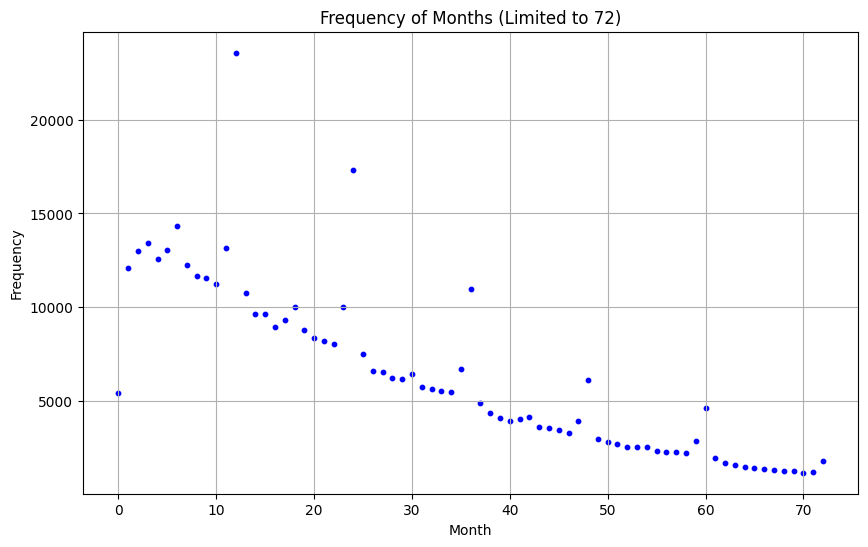

In [8]:
plot_data = frequency_month[frequency_month['month'] <= 72]

plt.figure(figsize=(10, 6))

plt.scatter(plot_data['month'], plot_data['count'], s=10, c='blue')

plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Frequency of Months (Limited to 72)')
plt.grid(True)  # Add grid

plt.show()